# Python Operator
This example shows how to run custom Python code using family of DALI `PythonFunction` Operators to prototype new augmentations or debug the Pipeline.
The idea behind these Operators is to provide a capability to execute Python code operating on DALI tensors' data within the pipeline execution. 

## Defining an operation
The first kind of Operator we will try is `PythonFunction`. It wraps a regular Python function and runs it inside a DALI Pipeline.
Let us define such a function as an example. We will name it `edit_images`.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np

def edit_images(image1, image2):
    assert image1.shape == image2.shape
    h, w, c = image1.shape
    y, x = np.ogrid[0:h, 0:w]
    mask = (x - w / 2) ** 2 + (y - h / 2) ** 2 > h * w / 9
    result1 = np.copy(image1)
    result1[mask] = image2[mask]
    result2 = np.copy(image2)
    result2[mask] = image1[mask]
    return result1, result2


In this case it takes two arrays as input and returns two outputs. The code creates a circular mask and uses it to swap those circular parts between two inputs.
`PythonFunction` uses NumPy arrays as data format for CPU and [CuPy](https://cupy.chainer.org/) arrays for GPU. Note that we do a copy of both images because the input data should not be modified.

## Test pipeline
To see the Operator in action, we implement a simple data pipeline. See that in addition to the function, we pass the number of outputs as a parameter. Having constructed `PythonFunction` as seen below, we can use it in the `define_graph` method like any other Operator.

In [2]:


image_dir = '../data/images'

class CommonPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(CommonPipeline, self).__init__(batch_size, num_threads, device_id, exec_async=False,
                                             exec_pipelined=False, seed=99)
        self.input1 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.input2 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='cpu', output_type=types.RGB)
        self.resize = ops.Resize(resize_x=300, resize_y=300)
        
    def load(self):
        jpegs1, labels = self.input1()
        jpegs2, labels = self.input2()
        im1, im2 = self.decode(jpegs1), self.decode(jpegs2)
        return self.resize(im1), self.resize(im2)
        

class PythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(PythonFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.edit_images = ops.PythonFunction(function=edit_images, num_outputs=2)

    def define_graph(self):
        images1, images2 = self.load()
        res1, res2 = self.edit_images(images1, images2)
        return res1, res2

### Running the pipeline and visualizing results
Now we can just run the pipeline as usual to see the results. 

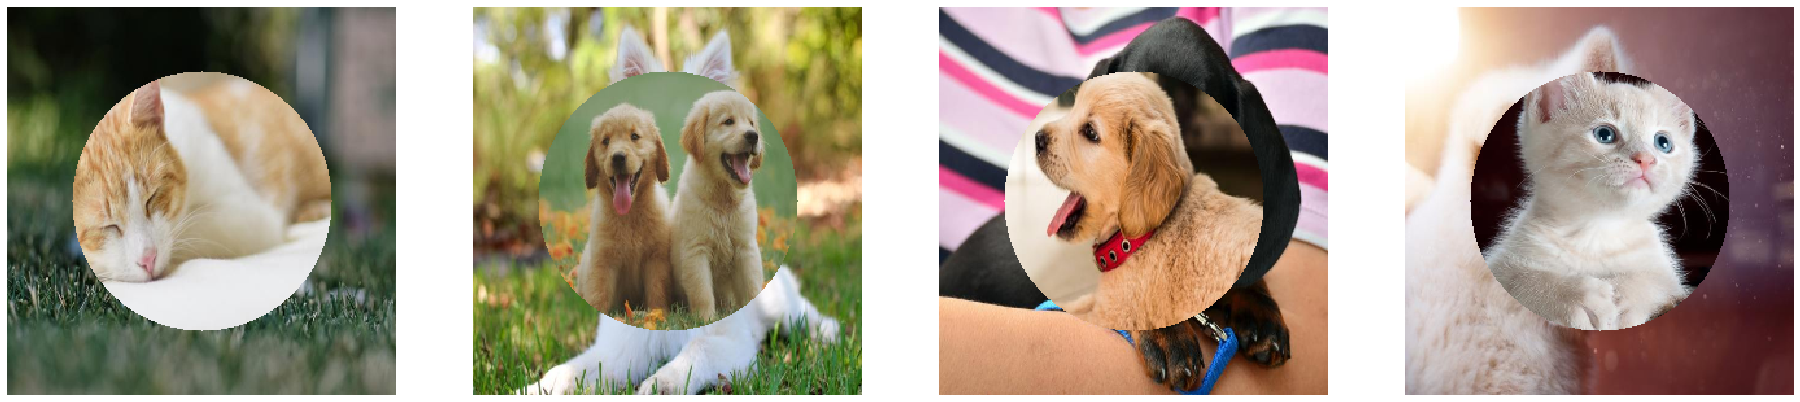

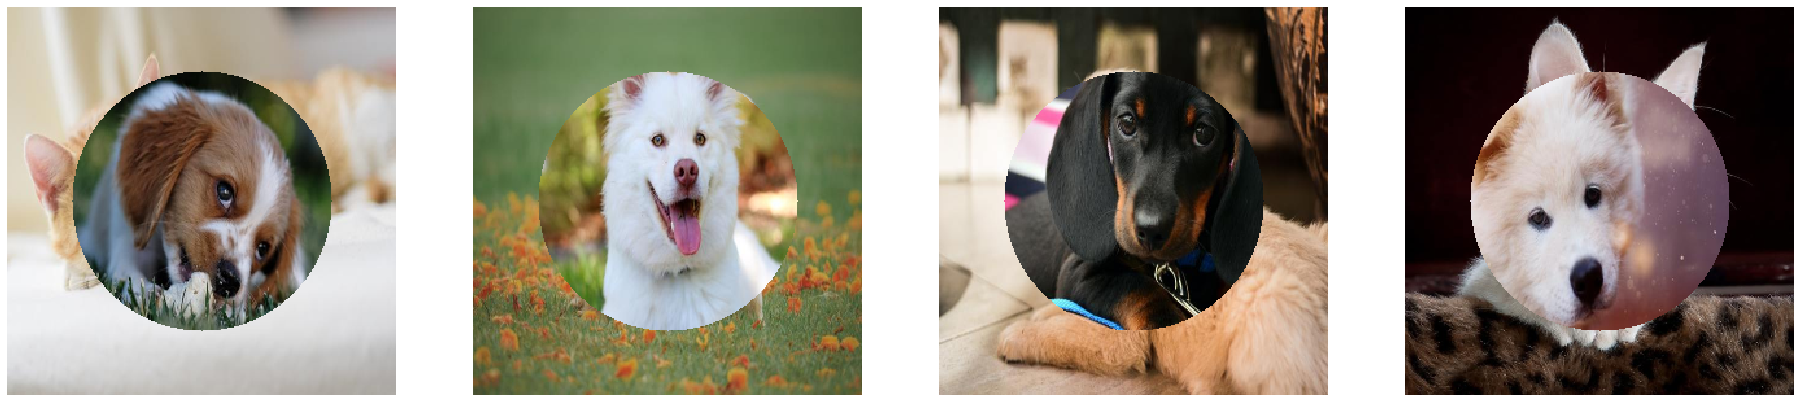

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))
        
        
pipe = PythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
ims1, ims2 = pipe.run()

show_images(ims1)
show_images(ims2)

## Variety of Python Operators
`PythonFunction` comes in different flavors in DALI. The basic idea stays the same but data format on which the implementation operates differs: 

* `PythonFunction` - works on arrays,
* `TorchPythonFunction` - works on PyTorch tensors,
* `DLTensorPythonFunction` - works on [DLPack](https://github.com/dmlc/dlpack) tensors.

The most universal of these is `DLTensorPythonFunction` as DLPack is an open standard for tensor storage and many frameworks and libraries implement conversion methods from and to DLPack tensors. Internally it is used to implement all the other kinds of Python Operator.

### TorchPythonFunction and DLTensorPythonFunction
The example below presents the usage or PyTorch functions inside DALI pipeline. The preferred way to do this would be just utilizing the `TorchPythonFunction` operator but the `DLTensorPythonFunction` is also used to show an example of converting DLPack tensors.

Also, notice that every Python operator has the `batch_processing` parameter. It says whether the implementation function will get the whole batch as a list of tensors or it will be called per sample. Due to historical reasons, for `DLTensorPythonFunction`, this parameter is set to *True* by default. We can look at `dlpack_manipulation` to see how to deal with this kind of input.

In [4]:
import nvidia.dali.plugin.pytorch as dalitorch
import torch
import torch.utils.dlpack as torch_dlpack
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToPILImage(),
                              transforms.RandomPerspective(p=1.),
                              transforms.ToTensor()])
def perspective(t):
    return transform(t).transpose(2, 0).transpose(0, 1)

def dlpack_manipulation(dlpacks):
    dlpacks.reverse()  # it is safe to modify an input list unless we do not modify tensors' contents.
    tensors = [torch_dlpack.from_dlpack(dlpack) for dlpack in dlpacks]
    output = [(tensor.to(torch.float32) / 255.).sqrt() for tensor in tensors]
    return [torch_dlpack.to_dlpack(tensor) for tensor in output]

class TorchFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(TorchFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.norm = ops.CropMirrorNormalize(std=255., mean=0.)
        self.perspective = dalitorch.TorchPythonFunction(function=perspective)
        self.sqrt_color = ops.DLTensorPythonFunction(function=dlpack_manipulation)
    
    def define_graph(self):
        images, _ = self.load()
        res1 = self.perspective(self.norm(images))
        res2 = self.sqrt_color(images)
        return res1, res2

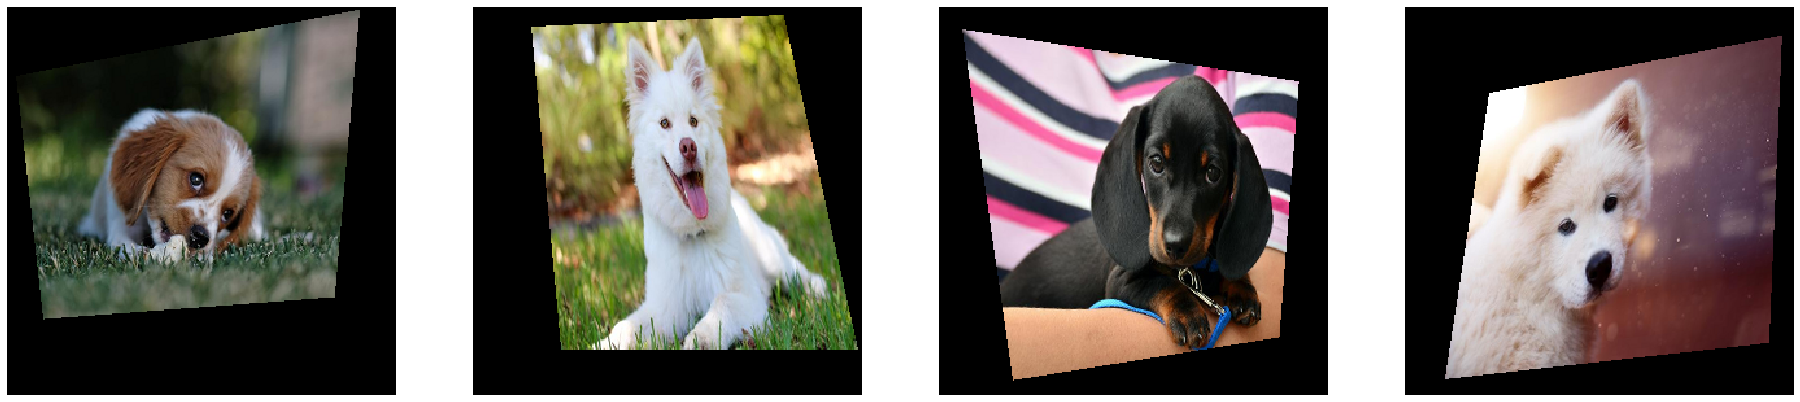

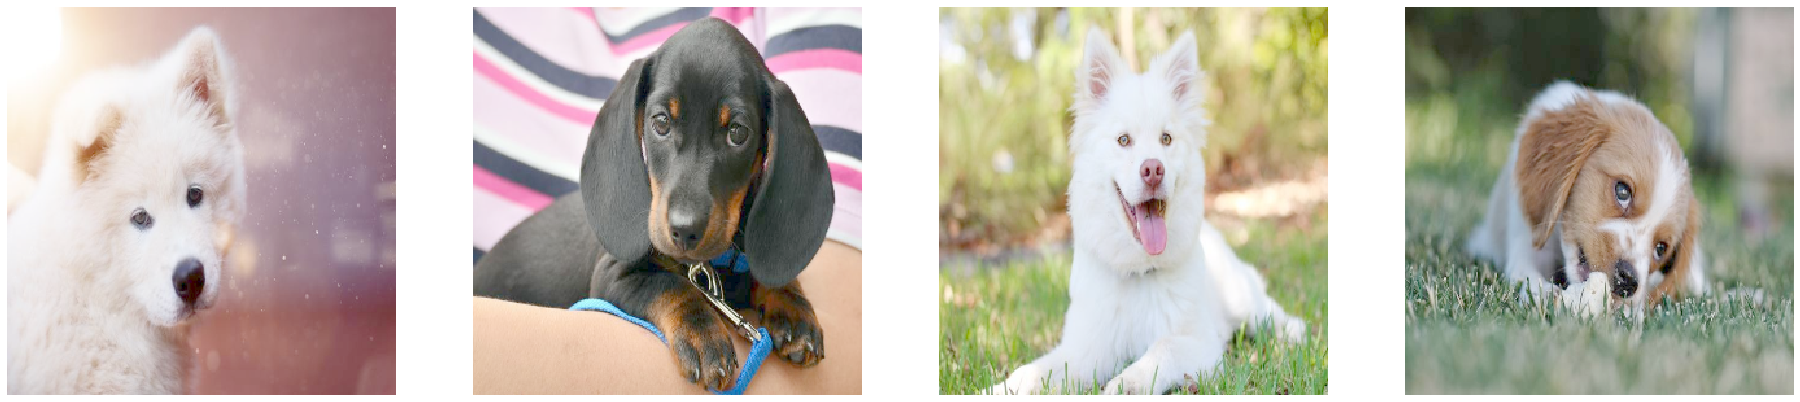

In [5]:
torch_pipeline = TorchFuncPipeline(4, 4, 0, image_dir)
torch_pipeline.build()

x, y = torch_pipeline.run()
show_images(x)
show_images(y)

## Limitations of Python operators
As we could see, pipelines that incorporate Python operators has to be constructed with `exec_async=False` and `exec_pipelined=False` specified. It was necesary to make it possible to call Python code from inside of DALI but it hits the performance of data pipelines. In addition to that, Python operators cannot utilize more than one CPU core due to Python threading model. Taking all that into account, Python operators can be very useful for testing, debugging or prototyping, but are not considered as a production level solution for extending DALI. 